# 5.3 AB test

**Идея**

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR)

**Метрика**

* Считается общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
* Расчет в обеих группах поюзерной метрики  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
* После чего сравнивается  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  

Это дает возможность увеличить чувствительность изначальной метрики (или, по крайней мере, не сделать хуже).

**Задача**
* Проанализировать тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
* Проанализировать тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

## Загрузка данных

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230320',
    'user':'student', 
    'password':'dpo_python_2020'
}

query = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-02' and '2023-03-08'
    and exp_group in (0,1,2,3)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)

In [3]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,1,18392,7,32,0.218750
2,3,123580,13,48,0.270833
3,2,131473,14,134,0.104478
4,2,32420,26,128,0.203125


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40079 entries, 0 to 40078
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   exp_group  40079 non-null  int8   
 1   user_id    40079 non-null  uint32 
 2   likes      40079 non-null  uint64 
 3   views      40079 non-null  uint64 
 4   ctr        40079 non-null  float64
dtypes: float64(1), int8(1), uint32(1), uint64(2)
memory usage: 1.1 MB


In [5]:
# количество пользователей в группах
df.groupby('exp_group').ctr.count().reset_index()

,exp_group,ctr
0,0,9999
1,1,10079
2,2,9952
3,3,10049


## Проведение эксперимента

In [6]:
# рассчет общего CTR в контрольных группах
ctr_0_control = sum(df[df.exp_group == 0]['likes'])/ sum(df[df.exp_group == 0]['views'])
ctr_1_control = sum(df[df.exp_group == 1]['likes'])/ sum(df[df.exp_group == 1]['views'])
print('CTR в контрольной группе №0 = ', round(ctr_0_control,5))
print('CTR в контрольной группе №1 = ', round(ctr_1_control,5))

CTR в контрольной группе №0 =  0.20824
CTR в контрольной группе №1 =  0.20803


In [7]:
# функция для рассчета линеаризированных лайков
def get_linearized_likes(user_likes, user_views, ctr_control):
    linearized_like = user_likes - ctr_control * user_views
    return linearized_like

In [8]:
# разделение данных на исследуемые группы (0,1 - контрольные группы; 3,2 - целевые группы)
group_03 = df[(df.exp_group == 0) | (df.exp_group == 3)].copy()
group_12 = df[(df.exp_group == 1) | (df.exp_group == 2)].copy()

### Группа №0 и №3 (0 - контрольная, 3 - целевая)

In [9]:
# применение функции для посчета линеаризированных лайков
group_03['linearized_like'] = group_03.apply(lambda x: get_linearized_likes(x['likes'], x['views'], ctr_0_control), axis=1)

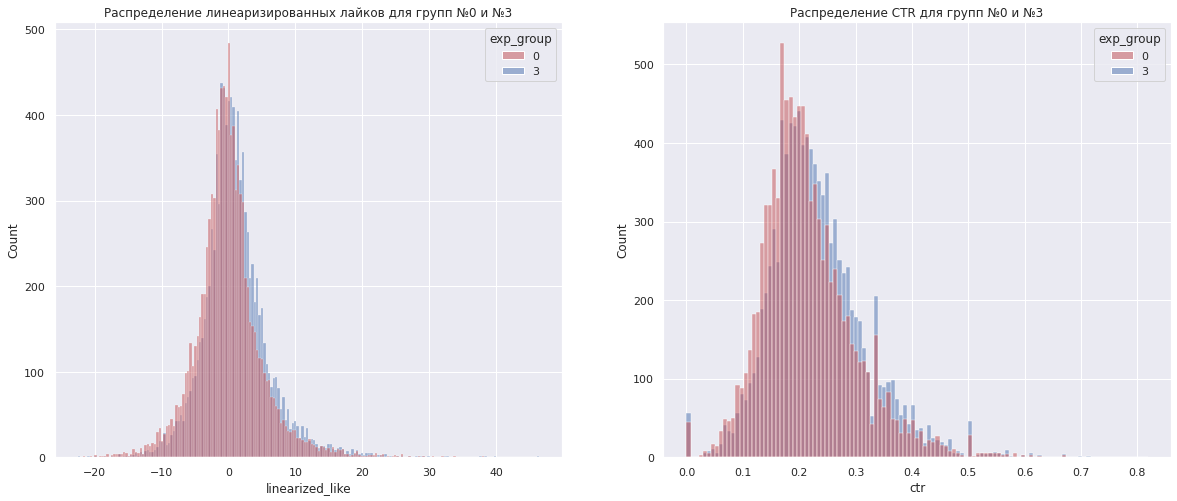

In [10]:
# распределение линеаризированных лайков на гистограмме
sns.set(rc={'figure.figsize':(20,8)})
sns.histplot(data = group_03, 
              x = 'linearized_like', 
              hue = 'exp_group',
              palette = ['r', 'b'],
              alpha = 0.5,
              kde = False,
            ax=plt.subplot(1, 2, 1))\
   .set(title = 'Распределение линеаризированных лайков для групп №0 и №3')
# распределение CTR на гистограмме
sns.histplot(data = group_03, 
              x = 'ctr', 
              hue = 'exp_group',
              palette = ['r', 'b'],
              alpha = 0.5,
              kde = False,
            ax=plt.subplot(1, 2, 2))\
   .set(title = 'Распределение CTR для групп №0 и №3');

Из графиков видно, что распределение метрики линеаризированных лайков более равномерное и похоже на нормальное, чем метрика CTR, в которой много значений меняющих форму распределения от нормального.

In [11]:
# расчет t-теста для группы №0-3 для метрики линеаризированных лайков
stats.ttest_ind(group_03[group_03['exp_group'] == 0].linearized_like,
                group_03[group_03['exp_group'] == 3].linearized_like,
                equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

In [12]:
# расчет t-теста для группы №0-3 для метрики CTR
stats.ttest_ind(group_03[group_03['exp_group'] == 0].ctr,
                group_03[group_03['exp_group'] == 3].ctr)

Ttest_indResult(statistic=-13.895802293872993, pvalue=1.071239841805842e-43)

In [13]:
# linearized_like(pvalue) < ctr(pvalue)
5.4914249479690016e-52 < 1.071239841805842e-43

True

Значения t-теста на обеих метриках крайне близки к 0, что говорит о том, что группы отличны между собой. Однако значение CTR оказалось все таки немного больше метрики линеаризированных лайков

### Группа №1 и №2 (1 - контрольная, 2 - целевая)

In [14]:
# применение функции для посчета линеаризированных лайков
group_12['linearized_like'] = group_12.apply(lambda x: get_linearized_likes(x['likes'], x['views'], ctr_1_control), axis=1)

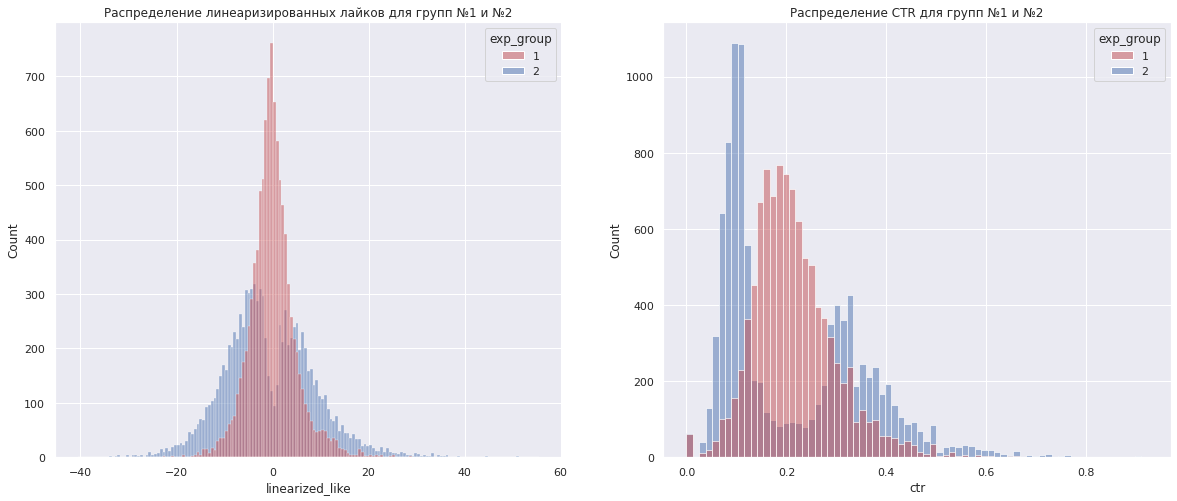

In [15]:
# распределение линеаризированных лайков на гистограмме
sns.set(rc={'figure.figsize':(20,8)})
sns.histplot(data = group_12, 
              x = 'linearized_like', 
              hue = 'exp_group',
              palette = ['r', 'b'],
              alpha = 0.5,
              kde = False,
            ax=plt.subplot(1, 2, 1))\
   .set(title = 'Распределение линеаризированных лайков для групп №1 и №2')
# распределение CTR на гистограмме
sns.histplot(data = group_12, 
              x = 'ctr', 
              hue = 'exp_group',
              palette = ['r', 'b'],
              alpha = 0.5,
              kde = False,
            ax=plt.subplot(1, 2, 2))\
   .set(title = 'Распределение CTR для групп №1 и №2');

Из графиков видно, что метрика линеаризированных лайков имеет такое же не нормально распределение как и CTR, однако для 2ой группы значения метрики линеаризированных лайков стали менее централизированными, рассеявшись по краям распределния, что менее выражено на показателе 1ой группы.

In [16]:
# расчет t-теста для группы №1-2 для метрики линеаризированных лайков
stats.ttest_ind(group_12[group_12['exp_group'] == 1].linearized_like,
                group_12[group_12['exp_group'] == 2].linearized_like,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775972, pvalue=9.439432187037712e-10)

In [17]:
# расчет t-теста для группы №1-2 для метрики CTR
stats.ttest_ind(group_12[group_12['exp_group'] == 1].ctr,
                group_12[group_12['exp_group'] == 2].ctr)

Ttest_indResult(statistic=0.7116545895251319, pvalue=0.4766869824114077)

Для группы №1-2 показатель pvalue уменьшился в разы, достигнув околонулевого значения, изменив толкование результата - теперь группы отличны между собой.

**Общий вывод**

Для одной эксперементальной группы применение новой метрики не сильно поменяло итоговую картину, однако для второй польностью измнило результат.